# Race relationship to cell proportions in Schildkraut HGSOC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
import seaborn as sns, matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_ind          # Welch test
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import sys 

sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../')

import src.hp as hp

np.random.seed(88)

In [ ]:
fractions  = ["Adipocytes", "Immune", "Stromal", "Epithelial"]

## Load survival metadata

In [ ]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx") 

remove_treatment = False
remove_pts_with_unknowns= True

map_stage = True
remove_unknown_stage = True

In [3]:
if use_only_cell:
    if cell_types_to_use:
        pass
    else:
        raise ValueError("If using only certain cell types, please specify which cell types to use.")

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [4]:
props = pd.read_csv(os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


In [5]:
## The order for the plots:
desired_order = [
    'Age',
    'BMI',
    'No Adj Tx.',
    'Race: Black',
    'Residual: < 1cm',
    'Residual: ≥ 1cm',
    'Residual: Unknown size',
]
if remove_treatment:
    desired_order.remove('No Adj Tx.')
    desired_order.remove('Residual: < 1cm')
    desired_order.remove('Residual: ≥ 1cm')
    desired_order.remove('Residual: Unknown size')
desired_order

['Age',
 'BMI',
 'No Adj Tx.',
 'Race: Black',
 'Residual: < 1cm',
 'Residual: ≥ 1cm',
 'Residual: Unknown size']

### Build the analysis table  (clinical + cell fractions)


In [6]:
renaming = {"suid"          : "ID",
                   "refage"        : "Age",
                   "vital_status_fin": "Event",
                   "years_extend"  : "Time_Yrs",
                    "tissue"  : "Tissue",
                   "stage"         : "Stage",
                   "race"          : "Race",
                   "dblk_treat"    : "Debulk",
                   "hispanic"      : "Hispanic",
                   "bmi_recent"    : "BMI",
                   "neoadj_treat" : "NeoTx",
                   "adj_treat"     : "AdjTx",
                   "resdis_treat"  : "Residual"}

In [7]:
tissue_dictionary = {"right ovary": "Ovary",
                     "left ovary": "Ovary",
                     "ovary": "Ovary",
                      "left ovarian mass": "Ovary",
                     "right fallopian tube": "Fallopian Tube",
                     "left fallopian tube": "Fallopian Tube",
                     "fallopian tube": "Fallopian Tube",
                     "left fallopian tube and ovary": "Fallopian Tube and Ovary",
                     "right fallopian tube and ovary": "Fallopian Tube and Ovary",
                     "right ovary and fallopian tube": "Fallopian Tube and Ovary",
                     "left ovary and fallopian tube": "Fallopian Tube and Ovary",
                     "bilateral tubes and ovaries: tumor including possible ovarian tissue": "Fallopian Tube and Ovary",
                     "tubes and ovaries/cancer": "Fallopian Tube and Ovary",
                     "fallopian tube and ovary": "Fallopian Tube and Ovary",
                     "omentum": "Omentum",
                     "omental tumor": "Omentum",
                     "omentum (note: ovarian primary)": "Omentum",
                     "omentum or peritoneum": "Omentum",
                     "peritoneum or omentum": "Omentum",
                     "omentum or cul-de-sac implant": "Omentum",
                     "umbilicus": "Other",
                     "left ovary with adherent omentum": "Other",
                     "representative section of mesenteric nodule": "Other",
                     "representative section of mesenteric nodule": "Other",
                     "representative sections of tumor":  "Other",
                     "posterior wall of myometrium": "Other",
                     "left ovary and peritoneum": "Other",
                     "omentum or ovary": "Other",
                     "fallopian tube or ovary": "Other",
                     "cervix and colon": "Other",
                     "probable adnexal structure with papillary mass": "Other",
                     "peritoneum": "Other",
                    }

cont_cols = ["Age", "BMI"]

Metadata

In [8]:
meta_full = hp.open_and_clean_meta(meta_path=meta_path,
                                    renaming=renaming, 
                                    tissue_dictionary=tissue_dictionary)

In [15]:
for col in meta_full:
    print(col)
    print(meta_full[col].value_counts(dropna=False))

ID
ID
40143     1
110295    1
110211    1
110212    1
110221    1
         ..
45380     1
45731     1
45762     1
45768     1
320047    1
Name: count, Length: 588, dtype: int64
Age
Age
63    30
57    30
56    26
64    26
59    22
55    20
62    19
53    19
52    19
67    19
50    18
60    18
71    18
61    17
51    17
70    17
54    17
68    15
58    15
73    15
72    14
45    14
49    14
66    14
69    13
48    13
47    13
65    13
46    11
74    11
44    10
43     9
40     7
42     6
39     5
78     4
77     4
41     3
76     3
35     3
37     2
36     1
31     1
33     1
38     1
26     1
Name: count, dtype: int64
Event
Event
1    471
0    117
Name: count, dtype: int64
Time_Yrs
Time_Yrs
2.598220     3
1.749487     3
0.769336     2
1.078713     2
10.461749    2
            ..
12.429843    1
17.656400    1
17.577002    1
2.004107     1
2.696721     1
Name: count, Length: 562, dtype: int64
Tissue
Tissue
NaN                         441
Ovary                        63
Fallopian Tube and 

In [20]:
meta_full.Time_Yrs.describe()

count    588.000000
mean       6.245635
std        4.908412
min        0.353183
25%        2.491180
50%        4.242042
75%        9.604653
max       21.256674
Name: Time_Yrs, dtype: float64

In [9]:
#match index in both
meta_full.index = meta_full.ID
props.index = props.ID
props.drop(columns=["ID", "SampleID", "suid"], inplace=True)

## and merge:
df = meta_full.join(props, how="inner")

cell_types = [col for col in df.columns if col not in meta_full.columns and col not in cont_cols]
cell_types.remove("Dataset")

df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset
ID,,,,,,,,,,,,,,,,,,,,,
40143,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,9.808751e-12,0.610632,1.004328e-110,2.784970e-66,3.408820e-86,2.396804e-02,1.848657e-50,0.0,0.113422,SchildkrautW
41377,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,1.760940e-62,0.702189,1.298550e-208,3.770200e-114,5.097006e-86,1.148229e-151,2.716906e-120,0.0,0.169611,SchildkrautW
41387,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,1.680504e-02,0.725604,1.103526e-97,9.654211e-04,3.169795e-58,6.457394e-02,9.868737e-88,0.0,0.064832,SchildkrautB
41391,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,2.241865e-19,0.660983,3.521124e-102,3.787996e-28,1.975079e-50,1.760802e-02,3.608451e-57,0.0,0.119373,SchildkrautW
41435,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,4.262662e-11,0.739953,8.402589e-122,2.637763e-60,2.022724e-88,5.507985e-03,3.092821e-03,0.0,0.110333,SchildkrautW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310266,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,1.374198e-10,0.777904,3.501752e-85,4.856912e-52,2.991107e-53,1.842305e-02,3.506149e-04,0.0,0.097551,SchildkrautB
320012,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,1.048037e-48,0.771372,3.272227e-203,2.444034e-102,2.676690e-115,2.749868e-124,8.635726e-145,0.0,0.135411,SchildkrautB
320025,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,6.829921e-59,0.660166,6.138234e-174,1.089373e-96,7.514971e-104,2.901155e-89,6.676818e-64,0.0,0.181209,SchildkrautB


In [10]:
# 1 = White/Other, 2 = Black  (per your dataset)
df["RaceBlack"] = (df["Race"] == 2).astype(int)      # 1 = Black, 0 = not-Black

df.RaceBlack.value_counts()
df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,RaceBlack
ID,,,,,,,,,,,,,,,,,,,,,
40143,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,0.610632,1.004328e-110,2.784970e-66,3.408820e-86,2.396804e-02,1.848657e-50,0.0,0.113422,SchildkrautW,0
41377,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,0.702189,1.298550e-208,3.770200e-114,5.097006e-86,1.148229e-151,2.716906e-120,0.0,0.169611,SchildkrautW,0
41387,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,0.725604,1.103526e-97,9.654211e-04,3.169795e-58,6.457394e-02,9.868737e-88,0.0,0.064832,SchildkrautB,1
41391,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,0.660983,3.521124e-102,3.787996e-28,1.975079e-50,1.760802e-02,3.608451e-57,0.0,0.119373,SchildkrautW,0
41435,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,0.739953,8.402589e-122,2.637763e-60,2.022724e-88,5.507985e-03,3.092821e-03,0.0,0.110333,SchildkrautW,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310266,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,0.777904,3.501752e-85,4.856912e-52,2.991107e-53,1.842305e-02,3.506149e-04,0.0,0.097551,SchildkrautB,1
320012,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,0.771372,3.272227e-203,2.444034e-102,2.676690e-115,2.749868e-124,8.635726e-145,0.0,0.135411,SchildkrautB,1
320025,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,0.660166,6.138234e-174,1.089373e-96,7.514971e-104,2.901155e-89,6.676818e-64,0.0,0.181209,SchildkrautB,1


In [11]:
# How many from each race evaluated.
df.Race.value_counts()

Race
1    316
2    272
Name: count, dtype: int64

In [11]:
## Which cell types to use
immune_cells = ["B cells",
                        'Mast cells',
                    'T cells',
                    'Monocytes',
                    'Plasma cells',
                    "NK cells", 
                    "DC",
                    "pDC",  
                    "Macrophages", 
                    "ILC"]

stromal_cells = ["Fibroblasts",
                        'Endothelial cells']

df["Immune"] = df[immune_cells].sum(axis=1)
df["Stromal"] = df[stromal_cells].sum(axis=1)
df["Epithelial"] = df["Epithelial cells"]

In [ ]:
# %% [markdown]
# ### Black vs White: one–way ANOVA on Adipocyte / Immune / Stromal fractions – Bonferroni


# ─────────────────────────────────────────────────────────────────────────────
# 4.  Plot fractions with Bonferroni-adjusted p < 0.05
# ─────────────────────────────────────────────────────────────────────────────

rows = []

for frac in fractions:
    w  = df.loc[df.RaceBlack == 0, frac]      # White/Other
    b  = df.loc[df.RaceBlack == 1, frac]      # Black

    t_stat, p_raw = ttest_ind(b, w, equal_var=False, nan_policy="omit")
    rows.append({"Fraction": frac,
                 "Mean_Black":  b.mean(),
                 "Mean_White":  w.mean(),
                 "Difference":  b.mean() - w.mean(),
                 "p_raw":       p_raw})

res = pd.DataFrame(rows)
res["p_bonf"] = multipletests(res.p_raw, method="bonferroni")[1]
res = res.sort_values("p_bonf")
print("\n=== Welch t-test results (Bonferroni) ===")
display(res.round(4))



=== Welch t-test results (Bonferroni) ===


,Fraction,Mean_Black,Mean_White,Difference,p_raw,p_bonf
2,Stromal,0.0901,0.0978,-0.0077,0.3280,0.9841
0,Adipocytes,0.1356,0.1346,0.0009,0.8260,1.0000
1,Immune,0.1111,0.1067,0.0044,0.3409,1.0000


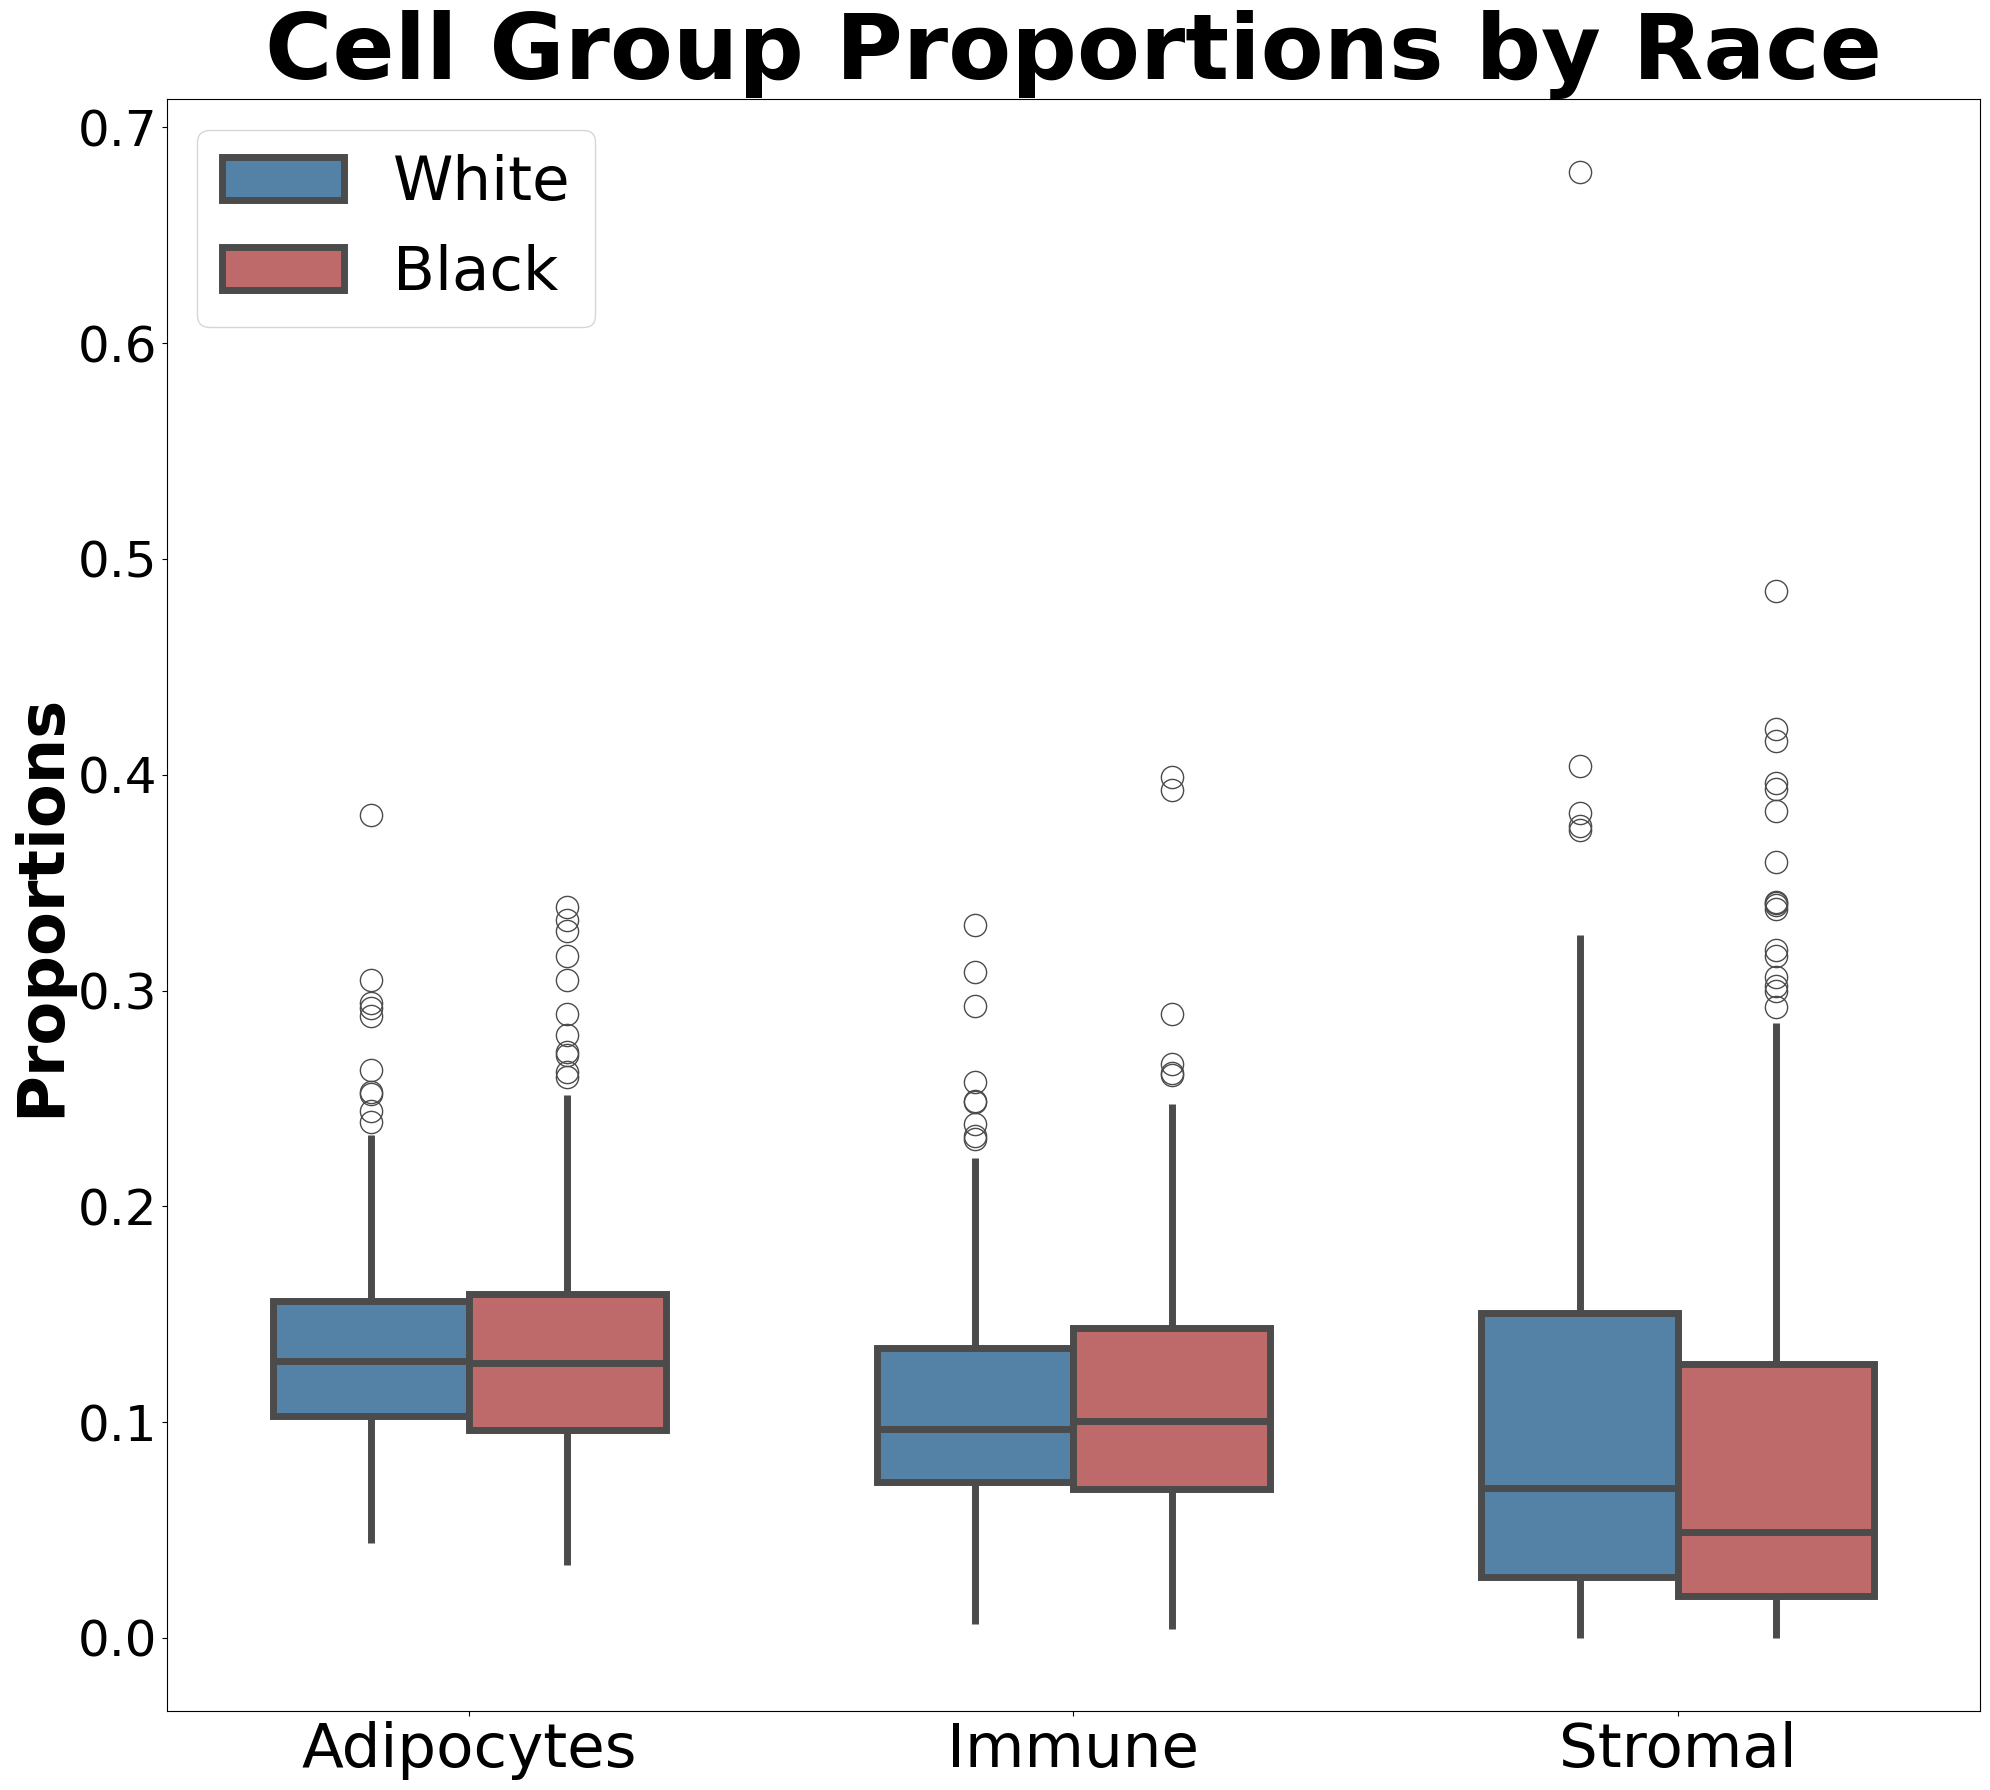

In [13]:
def p_to_star(p):
    return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

# ── 2.  Prep long-format table with *string* race labels ───────────────────
df["RaceStr"] = df.RaceBlack.map({0: "White", 1: "Black"})
long = (df[["RaceStr"] + fractions]
        .melt(id_vars="RaceStr", var_name="Fraction", value_name="Prop"))

palette = {"White": "steelblue", "Black": "indianred"}

# ── 3.  Plot ───────────────────────────────────────────────────────────────
plt.figure(figsize=(20,18))
ax = sns.boxplot(data=long, x="Fraction", y="Prop",
                 hue="RaceStr", hue_order=["White", "Black"],
                 palette=palette, width=.65,
                 showcaps=False, fliersize=16, linewidth=5)

# add stars only where Bonferroni-sig
for i, frac in enumerate(fractions):
    star = p_to_star(res.loc[res.Fraction == frac, "p_bonf"].values[0])
    if star:
        y_max = long.loc[long.Fraction == frac, "Prop"].max()
        ax.text(i, y_max + 0.02, star, ha="center",
                va="bottom", color="red", fontsize=46)

plt.ylabel("Proportions", fontsize=46, fontweight="bold")
plt.xlabel("", fontsize=46, fontweight="bold")
plt.title("Cell Group Proportions by Race",  fontsize=66, fontweight="bold")
plt.legend(title="",fontsize=44, loc='best')
plt.xticks(fontsize=44)
plt.yticks(fontsize=36)
plt.tight_layout()
plt.show()